In [1]:
import random
import math
import itertools
import numpy as np
import time
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
def generate_random_matrix(n):
    return [[random.choice([0, 1]) for _ in range(n)] for _ in range(n)]


def generate_random_vector(n, max_element=100):
    return [random.randint(0, max_element) for _ in range(n)] 

In [3]:
def multiply_vector_matrix(v, matrix):
    n = len(v)
    result = [0] * len(matrix[0])

    for i in range(len(matrix[0])):
        result[i] = sum(v[j] * matrix[j][i] for j in range(len(matrix)))

    return result

In [4]:
%%time
n = 2 ** 13
v, M = generate_random_vector(n), generate_random_matrix(n)

CPU times: user 18.3 s, sys: 192 ms, total: 18.4 s
Wall time: 18.4 s


In [5]:
%%time
result = multiply_vector_matrix(v, M)

CPU times: user 6.08 s, sys: 7.92 ms, total: 6.09 s
Wall time: 6.08 s


In [6]:
k = int(math.log(n, 2) - math.log(math.log(n, 2), 2))
k

9

In [7]:
def bucket_sort_rows(matrix):
    n, k = len(matrix), len(matrix[0])
    bucket = defaultdict(list)

    for row_tuple in itertools.product([0, 1], repeat=k):
        bucket[row_tuple] = []  # Create an empty list for each combination

    for i in range(n):
        row_tuple = tuple(matrix[i])
        bucket[row_tuple].append(i)

    sorted_indices = []
    for row_tuple in sorted(bucket):
        sorted_indices.append(tuple(bucket[row_tuple]))

    return sorted_indices

def preprocess(matrix, k):
    n = len(matrix)
    m = len(matrix[0])  # Assuming all rows have the same number of columns

    print("Original number of rows:", n)
    print("Number of columns:", m)
    
    # Check if m is divisible by k, if not, determine how many additional columns are needed
    additional_columns = 0
    if m % k != 0:
        additional_columns = k - (m % k)
        print("Additional columns needed:", additional_columns)

    # Create a new matrix with zero columns added
    new_matrix = [row + [0] * additional_columns for row in matrix]

    sorted_indices = []
    print("New number of columns:", len(new_matrix[0]))

    for split_idx in range(0, len(new_matrix[0]), k):
        submatrix = [row[split_idx:split_idx + k] for row in new_matrix]
        indices = bucket_sort_rows(submatrix)
        sorted_indices.append(indices)

    return sorted_indices, additional_columns


# Example: 
# matrix_example = [
#     [1, 0, 0, 1, 0, 1],
#     [0, 0, 1, 0, 1, 1],
#     [1, 1, 1, 0, 0, 0],
#     [0, 1, 1, 0, 1, 0],
#     [1, 0, 1, 0, 1, 0],
#     [0, 0, 0, 1, 1, 1]
# ]
# 
# k_example = 2
# sorted_indices = preprocess(matrix_example, k_example)
# sorted_indices

In [8]:
%%time
permutations, additional_columns = preprocess(M, k)

Original number of rows: 8192
Number of columns: 8192
Additional columns needed: 7
New number of columns: 8199
CPU times: user 46 s, sys: 276 ms, total: 46.3 s
Wall time: 46.3 s


In [9]:
def generate_binary_matrix(k):
    results = []
    for row_tuple in itertools.product([0, 1], repeat=k):
        results.append(list(row_tuple))
    return results


def smart_multiplication(v, k, permutations, additional_columns):
    results = []
    binary_matrix = generate_binary_matrix(k)

    for perm in permutations:
        new_v = []
        for t in perm:
            if not t:
                new_v.append(0)
            else:
                # Sum values of v at the indices specified in the current tuple
                segment_sum = sum(v[i] for i in t)
                new_v.append(segment_sum)
        results.extend(multiply_vector_matrix(new_v, binary_matrix))

    return results[:-additional_columns]

In [10]:
%%time
res = smart_multiplication(v, k, permutations, additional_columns)

CPU times: user 880 ms, sys: 0 ns, total: 880 ms
Wall time: 879 ms


In [11]:
assert res == result, "The two lists are not equal!"

## Evaluation

In [ ]:
sizes = [2**i for i in range(8, 14)]
multiply_times = []
smart_multiply_times = []
preprocess_times = []

for n in sizes:
    v = generate_random_vector(n)
    M = generate_random_matrix(n)
    k = int(math.log(n, 2) - math.log(math.log(n, 2), 2))

    # Measure multiply_vector_matrix
    multiply_runtime = []
    for _ in range(4):
        start_time = time.time()
        result = multiply_vector_matrix(v, M)
        multiply_runtime.append(time.time() - start_time)

    multiply_times.append(np.mean(multiply_runtime))

    # Measure smart_multiplication
    start_time = time.time()
    permutations, additional_columns = preprocess(M, k)
    preprocess_times.append(time.time() - start_time)

    smart_multiply_runtime = []
    for _ in range(4):
        start_time = time.time()
        res = smart_multiplication(v, k, permutations, additional_columns)
        smart_multiply_runtime.append(time.time() - start_time)

    smart_multiply_times.append(np.mean(smart_multiply_runtime))

Original number of rows: 256
Number of columns: 256
Additional columns needed: 4
New number of columns: 260
Original number of rows: 512
Number of columns: 512
Additional columns needed: 3
New number of columns: 515
Original number of rows: 1024
Number of columns: 1024
Additional columns needed: 2
New number of columns: 1026
Original number of rows: 2048
Number of columns: 2048
Additional columns needed: 3
New number of columns: 2051
Original number of rows: 4096
Number of columns: 4096
New number of columns: 4096


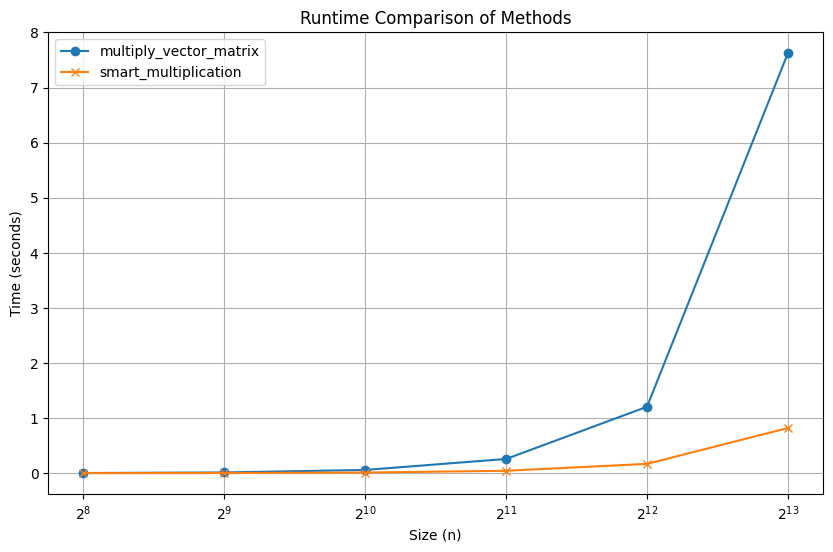

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(sizes, multiply_times, label='multiply_vector_matrix', marker='o')
plt.plot(sizes, smart_multiply_times, label='smart_multiplication', marker='x')
plt.plot(sizes, preprocess_times, label='smart_multiplication', marker='x')
plt.xscale('log', base=2)
plt.xlabel('Size (n)')
plt.ylabel('Time (seconds)')
plt.title('Runtime Comparison of Methods')
plt.legend()
plt.grid(True)
plt.show()